# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**

In [1]:
import os
import random
import gymnasium as gym
import numpy as np
import pandas as pd

from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from itertools import product
from tqdm.auto import tqdm
import seaborn as sns

import multiprocessing as mp

In [2]:
def softmax(x, temp=1.0):
    """
    Compute the softmax of each element along an axis of X with temperature adjustment.
    When temp is 0, the function returns an argmax-like result.

    Parameters:
    x (array_like): Input data.
    temp (float, optional): Temperature parameter to adjust the sharpness of softmax. Default is 1.0.

    Returns:
    array_like: Softmax-transformed output with the same shape as input x.
    """
    if temp == 0:
        # Simulate argmax behavior for zero temperature
        return np.equal(x, np.max(x, axis=-1, keepdims=True)).astype(float)
    else:
        # Adjust for temperature and improve numerical stability in one step
        z = (x - np.max(x, axis=-1, keepdims=True)) / temp
        top = np.exp(z)
        bottom = np.sum(top, axis=-1, keepdims=True)
        return top / bottom

In [3]:
class Sarsa:
    """
    A class representing the SARSA learning algorithm.

    Attributes:
    env (gym.Env): The environment to interact with.
    alpha (float): The learning rate.
    gamma (float): The discount factor for future rewards.
    temp (float): The temperature parameter for softmax action selection.
    Q (numpy.ndarray): The Q-table for storing state-action values.

    Methods:
    select_action(s, action_mask, greedy=False): Selects an action based on the current policy.
    update(s, a, r, s_prime, a_prime, done): Updates the Q-table based on the observed transition.
    """

    def __init__(self, env, alpha, gamma, temp):
        """
        Initializes the SARSA agent.

        Parameters:
        env (gym.Env): The environment to interact with.
        alpha (float): The learning rate.
        gamma (float): The discount factor for future rewards.
        temp (float): The temperature parameter for softmax action selection.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros([env.observation_space.n, env.action_space.n])
    
    def select_action(self, s, action_mask, greedy=False):
        """
        Selects an action based on the current policy.

        Parameters:
        s (int): The current state.
        action_mask (numpy.ndarray): A mask indicating allowed actions in the current state.
        greedy (bool): If True, selects the action with the highest Q-value.

        Returns:
        int: The selected action.
        """
        # Filter out actions that are not allowed in the current state
        allowed = np.where(action_mask == 1)[0]
        # Extract Q-values for the allowed actions
        Q_actions = self.Q[s, allowed]
        
        if greedy:
            # If greedy, select the action with the highest Q-value
            maximal = np.where(Q_actions == np.max(Q_actions))[0]
            return np.random.choice(maximal)
        else:
            # Otherwise, select an action based on a softmax distribution
            return random.choices(allowed, softmax(Q_actions, temp=self.temp), k=1)[0]

    
    def update(self, s, a, r, s_prime, a_prime, done, action_mask=None):
        """
        Updates the Q-table based on the observed transition.

        Parameters:
        s (int): The current state.
        a (int): The action taken.
        r (float): The reward received.
        s_prime (int): The next state.
        a_prime (int): The action taken in the next state.
        done (bool): Whether the episode has ended.
        action_mask (numpy.ndarray): A mask indicating allowed actions in state s_prime.

        Returns:
        tuple: The next state and action.
        """
        # Calculate the Q-value for the next state-action pair if not in a terminal state
        Q_prime = 0 if done else self.Q[s_prime, a_prime]
        # Update the Q-value for the current state-action pair
        self.Q[s, a] += self.alpha * (r + self.gamma * Q_prime - self.Q[s, a])
        return s_prime, a_prime

In [4]:
class ExpectedSarsa:
    """
    A class representing the SARSA learning algorithm.

    Attributes:
    env (gym.Env): The environment to interact with.
    alpha (float): The learning rate.
    gamma (float): The discount factor for future rewards.
    temp (float): The temperature parameter for softmax action selection.
    Q (numpy.ndarray): The Q-table for storing state-action values.

    Methods:
    select_action(s, action_mask, greedy=False): Selects an action based on the current policy.
    update(s, a, r, s_prime, a_prime, done): Updates the Q-table based on the observed transition.
    """

    def __init__(self, env, alpha, gamma, temp):
        """
        Initializes the SARSA agent.

        Parameters:
        env (gym.Env): The environment to interact with.
        alpha (float): The learning rate.
        gamma (float): The discount factor for future rewards.
        temp (float): The temperature parameter for softmax action selection.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.Q = np.zeros([env.observation_space.n, env.action_space.n])

    def select_action(self, s, action_mask, greedy=False):
        """
        Selects an action based on the current policy.

        Parameters:
        s (int): The current state.
        action_mask (numpy.ndarray): A mask indicating allowed actions in the current state.
        greedy (bool): If True, selects the action with the highest Q-value.

        Returns:
        int: The selected action.
        """
        # Filter out actions that are not allowed in the current state
        allowed = np.where(action_mask == 1)[0]
        # Extract Q-values for the allowed actions
        Q_actions = self.Q[s, allowed]
        
        if greedy:
            # If greedy, select the action with the highest Q-value
            maximal = np.where(Q_actions == np.max(Q_actions))[0]
            return np.random.choice(maximal)
        else:
            # Otherwise, select an action based on a softmax distribution
            return random.choices(allowed, softmax(Q_actions, temp=self.temp), k=1)[0]
    
    def update(self, s, a, r, s_prime, a_prime, done, action_mask):
        """
        Updates the Q-table based on the observed transition.
    
        Parameters:
        s (int): The current state.
        a (int): The action taken.
        r (float): The reward received.
        s_prime (int): The next state.
        a_prime (int): The action taken in the next state.
        done (bool): Whether the episode has ended.
        action_mask (numpy.ndarray): A mask indicating allowed actions in state s_prime.
        """
        # Calculate the Q-value for the next state-action pair if not in a terminal state
        if done:
            target = r
        else:
            # Apply the action mask to filter out disallowed actions
            allowed_actions = np.where(action_mask == 1)[0]
            Q_prime = self.Q[s_prime, allowed_actions]
            pi = softmax(Q_prime, self.temp)
            
            # Calculate the expected value considering only allowed actions
            expected_q = np.sum(pi * Q_prime)
            target = r + self.gamma * expected_q
    
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])
        return s_prime, a_prime

In [5]:
# # bonus question, optional
# class Hybrid_Sarsa_Q:
#   def __init__(self, env, alpha, gamma, temp):
#     # write your solution here
#     self.env = None
#     self.alpha = None
#     self.gamma = None
#     self.temp = None
#     self.Q = None
#     return

#   def select_action(self, s, greedy=False):
#     # write your solution here
#     if greedy:
#       # if finished training, then choose the optimal policy
#       return
#     else:
#       return

#   def update(self, s, a, r, s_prime, a_prime, done):
#     # write your solution here
#     return

# Write your experiment code below

In [6]:
def run_trial(args, env=None):
    """
    Runs a single trial of the given RL-algorithm on a given environment.

    Parameters:
    temp (float): Temperature parameter for model.
    alpha (float): Learning rate for model.
    gamma (float): Discount factor for model.
    n_segments (int): Number of segments to divide the trial into.
    n_episodes (int): Number of episodes per segment.

    Returns:
    dict: A dictionary containing the history of training and testing rewards.
    """
    model_name, run, trial, temp, alpha, gamma, n_segments, n_episodes = args

    if env is None:
        env = gym.make("Taxi-v3")

    model_dict = dict(sarsa=Sarsa, expected_sarsa=ExpectedSarsa)
        
    model = model_dict[model_name](env, alpha=alpha, gamma=gamma, temp=temp)
    train_history = []
    test_history = []

    # Outer loop for segments with progress bar
    for segment in range(n_segments):
        # Training episodes for this segment
        for episode in range(n_episodes):
            s, info = env.reset()
            total_reward = 0
            for step in range(200):
                action_mask = info.get("action_mask", None)
                a = model.select_action(s, action_mask)
                s_prime, r, done, trunc, info = env.step(a)
                total_reward += r
                if done:
                    break
                action_mask = info.get("action_mask", None)
                a_prime = model.select_action(s_prime, action_mask)
                s, a = model.update(s, a, r, s_prime, a_prime, done, action_mask)
            train_history.append({
                'model_name': model_name,
                'run': run,
                'trial': trial,
                'segment': segment,
                'episode': episode,
                'reward': total_reward,
                'alpha': alpha,
                'gamma': gamma,
                'temp': temp
            })

        # Testing episodes for this segment
        s, info = env.reset()  # Reset the environment for a test episode
        total_reward = 0
        for step in range(200):
            action_mask = info.get("action_mask", None)  # Ensure action_mask is updated correctly
            a = model.select_action(s, action_mask, greedy=True)  # Select action using the updated action_mask
            s_prime, r, done, trunc, info = env.step(a)
            total_reward += r
            if done:
                break
            s = s_prime  # Update state for the next step
        test_history.append({
            'model_name': model_name,
            'run': run,
            'trial': trial,
            'segment': segment,
            'reward': total_reward,
            'alpha': alpha,
            'gamma': gamma,
            'temp': temp
            # Removed 'episode': episode from the test history to avoid confusion
        })
        
    return train_history, test_history


def run_trial_with_index(indexed_param):
    index, params = indexed_param
    # Call the actual trial function with the provided environment
    train_history, test_history = run_trial(params)
    return (index, (train_history, test_history))


def process_history(history):
    dfs = []
    for trial, data in enumerate(history):
        df = pd.DataFrame(data)
        dfs.append(df[['model_name', 'run', 'trial', 'segment', 'episode', 'alpha', 'gamma', 'temp', 'reward']])
    
    result = pd.concat(dfs).reset_index(drop=True)
    result['return'] = (result
        .groupby(['run'])['reward']
        .apply(np.cumsum, include_groups=True)
        .reset_index(drop=True)
    )
    result['step'] = result.groupby(['run', 'trial']).cumcount()
    return result


def prepare_params(trial_params):
    # Create a list of parameters along with original indices
    indexed_params_list = list(enumerate(trial_params))
    # Shuffle the list to run trials in random order
    random.shuffle(indexed_params_list)
    return indexed_params_list


def sort_and_process_results(results_with_indices):
    # Sort the results back into their original order
    sorted_results = sorted(results_with_indices, key=lambda x: x[0])
    # Extract the results without indices
    sorted_results_without_indices = [result for _, result in sorted_results]

    train_history, test_history = zip(*sorted_results_without_indices)
    train_df = process_history(train_history)
    test_df = process_history(test_history)    

    return train_df, test_df


def run_parallel_trials(trial_params):
    indexed_params_list = prepare_params([(param["model_name"], param["run"], param["trial"], param["temp"], 
                                           param["alpha"], param["gamma"], param["n_segments"], param["n_episodes"]) 
                                          for param in trial_params])
    
    pool = Pool(processes=cpu_count())
    results_with_indices = list(tqdm(pool.imap(run_trial_with_index, indexed_params_list), total=len(indexed_params_list)))
    pool.close()
    pool.join()

    return sort_and_process_results(results_with_indices)


def run_sequential_trials(trial_params):
    indexed_params_list = prepare_params(trial_params)
    
    results_with_indices = []
    for index, param in tqdm(indexed_params_list, total=len(trial_params), leave=True):
        result = run_trial((param["model_name"], param["run"], param["trial"], param["temp"], 
                            param["alpha"], param["gamma"], param["n_segments"], param["n_episodes"]))
        results_with_indices.append((index, result))
    
    return sort_and_process_results(results_with_indices)


# Defining the grids
grid_size = 8
model_names = ['sarsa', 'expected_sarsa']
temps = np.linspace(0.01, 0.8, num=grid_size)
alphas = np.logspace(np.log10(0.6), np.log10(1.0), num=grid_size)
gammas = [0.95]  # formerly np.linspace(0.85, 1.0, num=100)

# Constants
n_trials = 10      # How many trials for each combination
n_segments = 500   # How many segments in a trial
n_episodes = 10    # How many episodes in a segment & how often to run test

def sample_params(model_names, temps, alphas, gammas, n_trials):
    for run, params in enumerate(product(model_names, temps, alphas, gammas)):
        model_name, temp, alpha, gamma = params
        for trial in range(n_trials):
            yield {
                "model_name": model_name,
                "run": run,
                "trial": trial,
                "temp": temp,
                "alpha": alpha,
                "gamma": gamma,
                "n_segments": n_segments,
                "n_episodes": n_episodes
            }

# Example of sampling a set of parameters
trial_params = [params for params in sample_params(model_names, temps, alphas, gammas, n_trials)]

In [7]:
print('temps:', temps)
print('alphas:', alphas)

temps: [0.01       0.12285714 0.23571429 0.34857143 0.46142857 0.57428571
 0.68714286 0.8       ]
alphas: [0.6        0.64542224 0.69428312 0.74684295 0.80338175 0.86420076
 0.92962399 1.        ]


In [8]:
# train_df, test_df = run_sequential_trials(trial_params)

In [9]:
! rm -rf data/*.csv

In [10]:
%%time
if not os.path.exists('data/train_df.csv') or not os.path.exists('data/test_df.csv'):
    train_df, test_df = run_parallel_trials(trial_params)
    train_df.to_csv('data/train_df.csv', index=False)
    test_df.to_csv('data/test_df.csv', index=False)
else:
    train_df = pd.read_csv('data/train_df.csv')
    test_df = pd.read_csv('data/test_df.csv')

CPU times: user 7.85 s, sys: 5.83 s, total: 13.7 s
Wall time: 13.7 s


In [11]:
train_df

,model_name,run,trial,segment,episode,alpha,gamma,temp,reward,return,step
0,sarsa,0,0,0,0,0.6,0.95,0.01,-200,-200,0
1,sarsa,0,0,0,1,0.6,0.95,0.01,-200,-400,1
2,sarsa,0,0,0,2,0.6,0.95,0.01,-200,-600,2
3,sarsa,0,0,0,3,0.6,0.95,0.01,-158,-758,3
4,sarsa,0,0,0,4,0.6,0.95,0.01,-200,-958,4
...,...,...,...,...,...,...,...,...,...,...,...
6399995,expected_sarsa,127,9,499,5,1.0,0.95,0.80,-13,-70269,4995
6399996,expected_sarsa,127,9,499,6,1.0,0.95,0.80,0,-70269,4996
6399997,expected_sarsa,127,9,499,7,1.0,0.95,0.80,4,-70265,4997
6399998,expected_sarsa,127,9,499,8,1.0,0.95,0.80,0,-70265,4998


In [12]:
test_df

,model_name,run,trial,segment,episode,alpha,gamma,temp,reward,return,step
0,sarsa,0,0,0,9,0.6,0.95,0.01,-200,-200,0
1,sarsa,0,0,1,9,0.6,0.95,0.01,-200,-400,1
2,sarsa,0,0,2,9,0.6,0.95,0.01,-200,-600,2
3,sarsa,0,0,3,9,0.6,0.95,0.01,-200,-800,3
4,sarsa,0,0,4,9,0.6,0.95,0.01,-200,-1000,4
...,...,...,...,...,...,...,...,...,...,...,...
639995,expected_sarsa,127,9,495,9,1.0,0.95,0.80,-200,-999200,495
639996,expected_sarsa,127,9,496,9,1.0,0.95,0.80,-200,-999400,496
639997,expected_sarsa,127,9,497,9,1.0,0.95,0.80,-200,-999600,497
639998,expected_sarsa,127,9,498,9,1.0,0.95,0.80,-200,-999800,498


In [13]:
good_runs = train_df[train_df.step == train_df.step.max()].sort_values("return", ascending=False).head(10).run.values

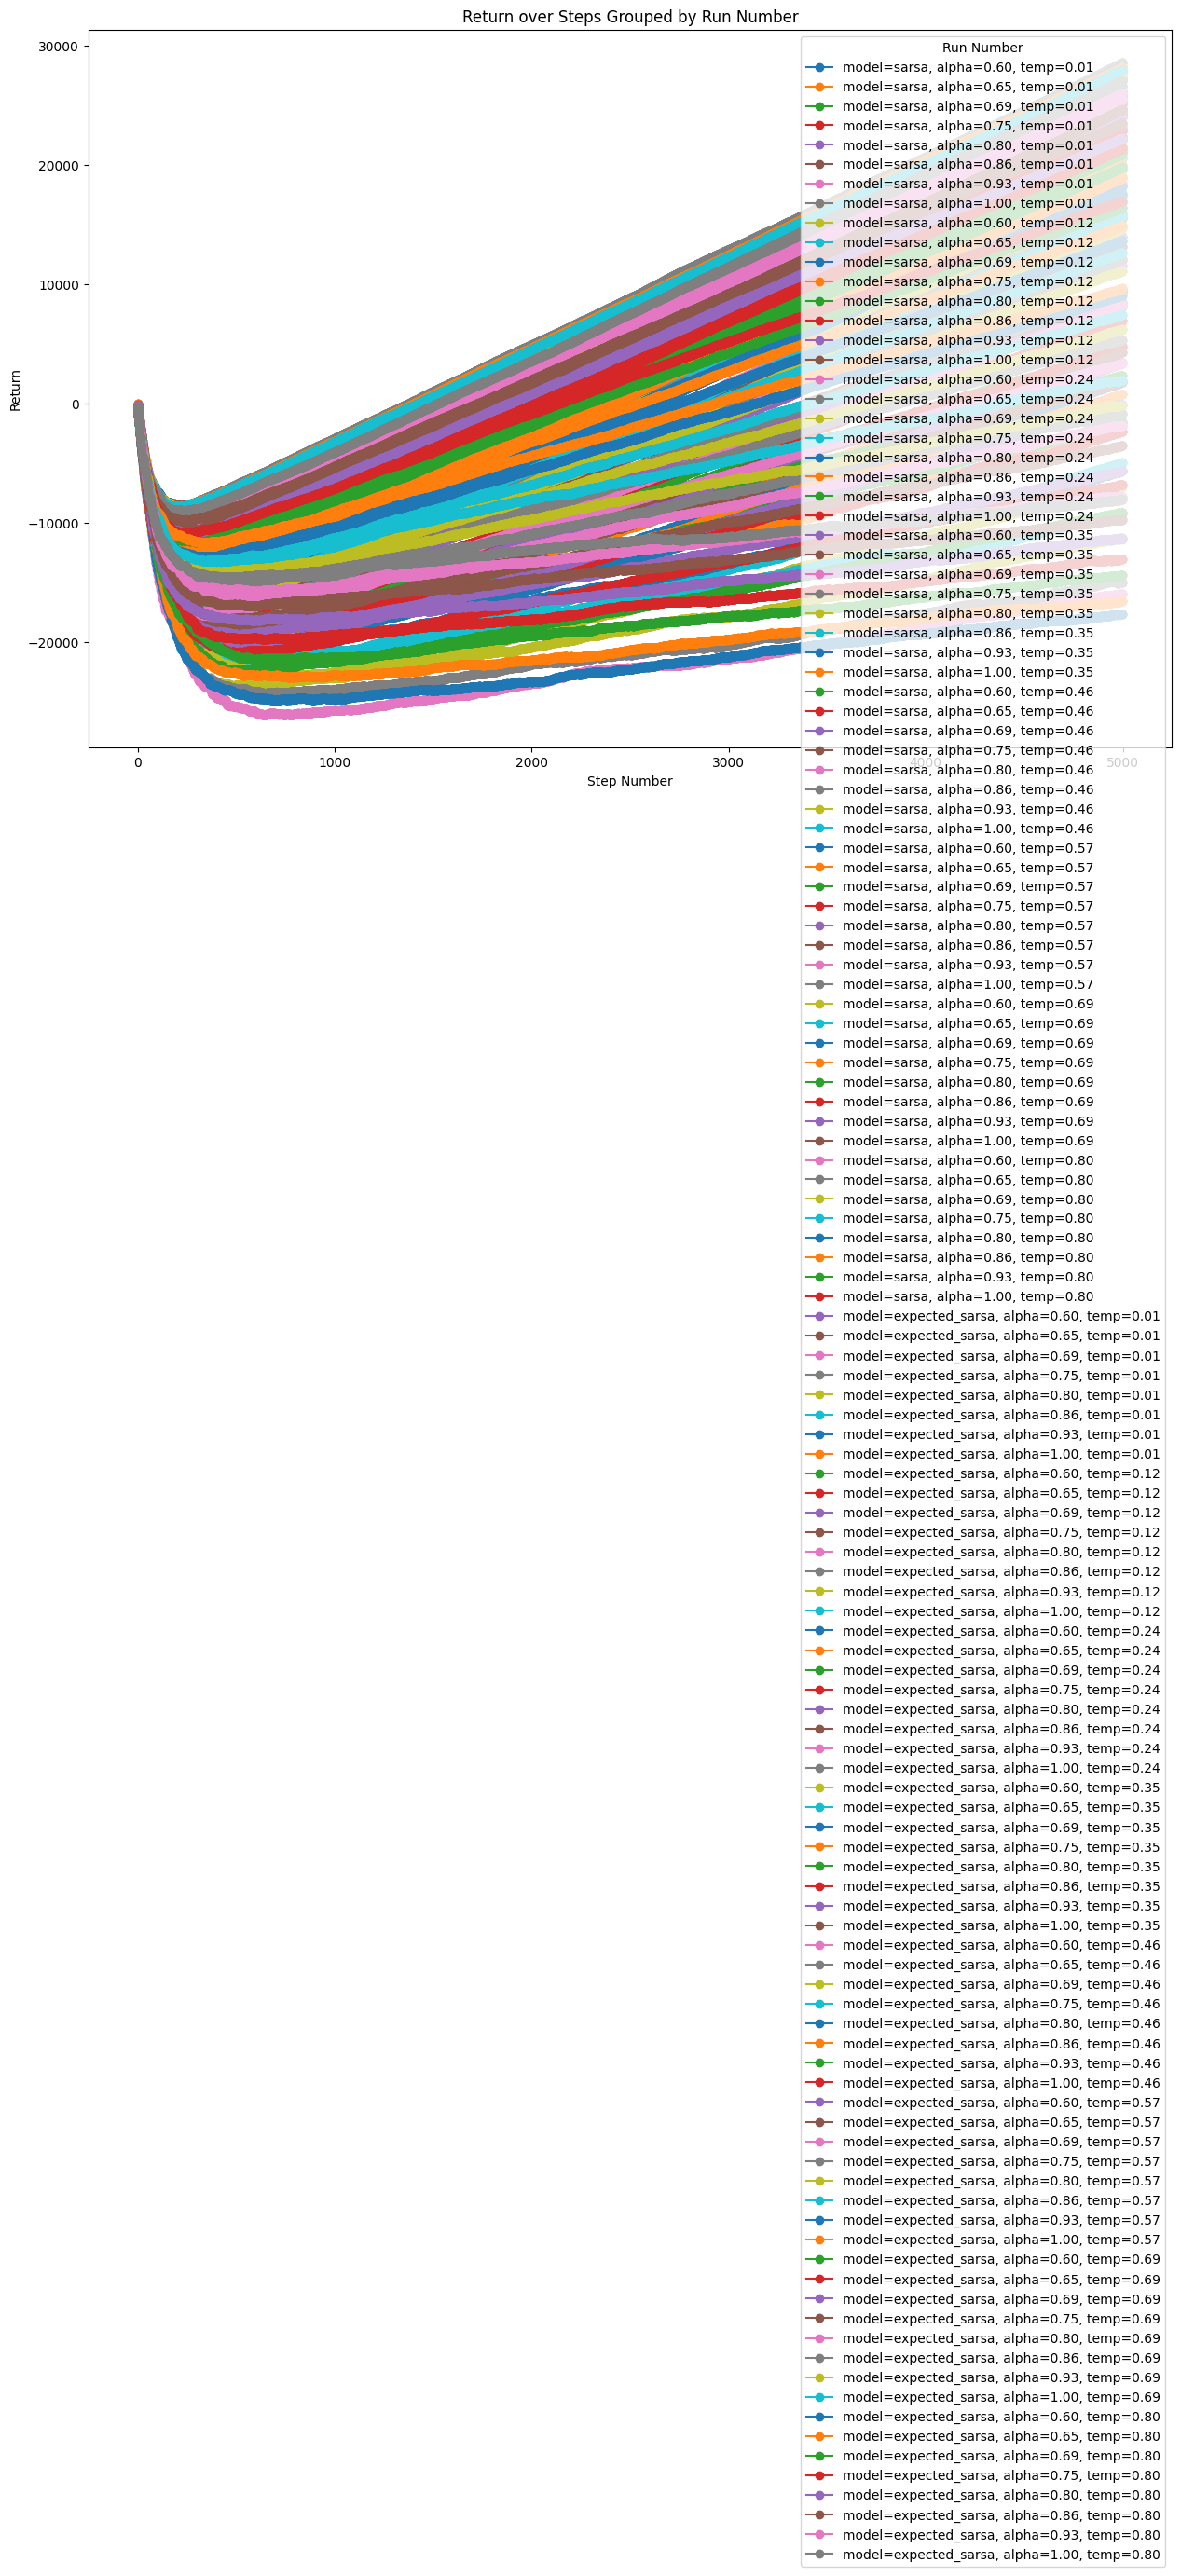

In [14]:
es_df = train_df[train_df.trial < 1]

# Assuming `df` is your DataFrame with the data provided
# Here we group by 'run' and then plot each group
groups = es_df.groupby(['run', 'trial'])

plt.figure(figsize=(15, 10))  # Set the figure size as desired

for name, group in groups:
    model_name, alpha, temp, trial = group.reset_index(drop=True).loc[0,['model_name', 'alpha', 'temp', 'trial']].values
    label = f'model={model_name}, alpha={alpha:.2f}, temp={temp:.2f}'
    plt.plot(group['step'], group['return'], marker='o', linestyle='-', label=label)

plt.xlabel('Step Number')
plt.ylabel('Return')
plt.title('Return over Steps Grouped by Run Number')
plt.legend(title='Run Number')
plt.show()

## The graphs

### Graph 1

One graph that shows the effect of the parameters on the final **training** performance.

The x-axis shows the different parameters (e.g. learning rate), and the y-axis shows the return
of the agent (averaged over the last 10 training episodes and the 10 runs); note that this will
typically end up as an upside-down U.
    
**For each algorithm**, the graph should have at least 3 lines (e.g. 3 temperature values) corre-
sponding to the choices of the other hyperparameter. There should be at least 6 lines in the
graph, and at least 18 different points. Also plot the uncertainty using shading (e.g. using the
min and the max return of the 10 runs)

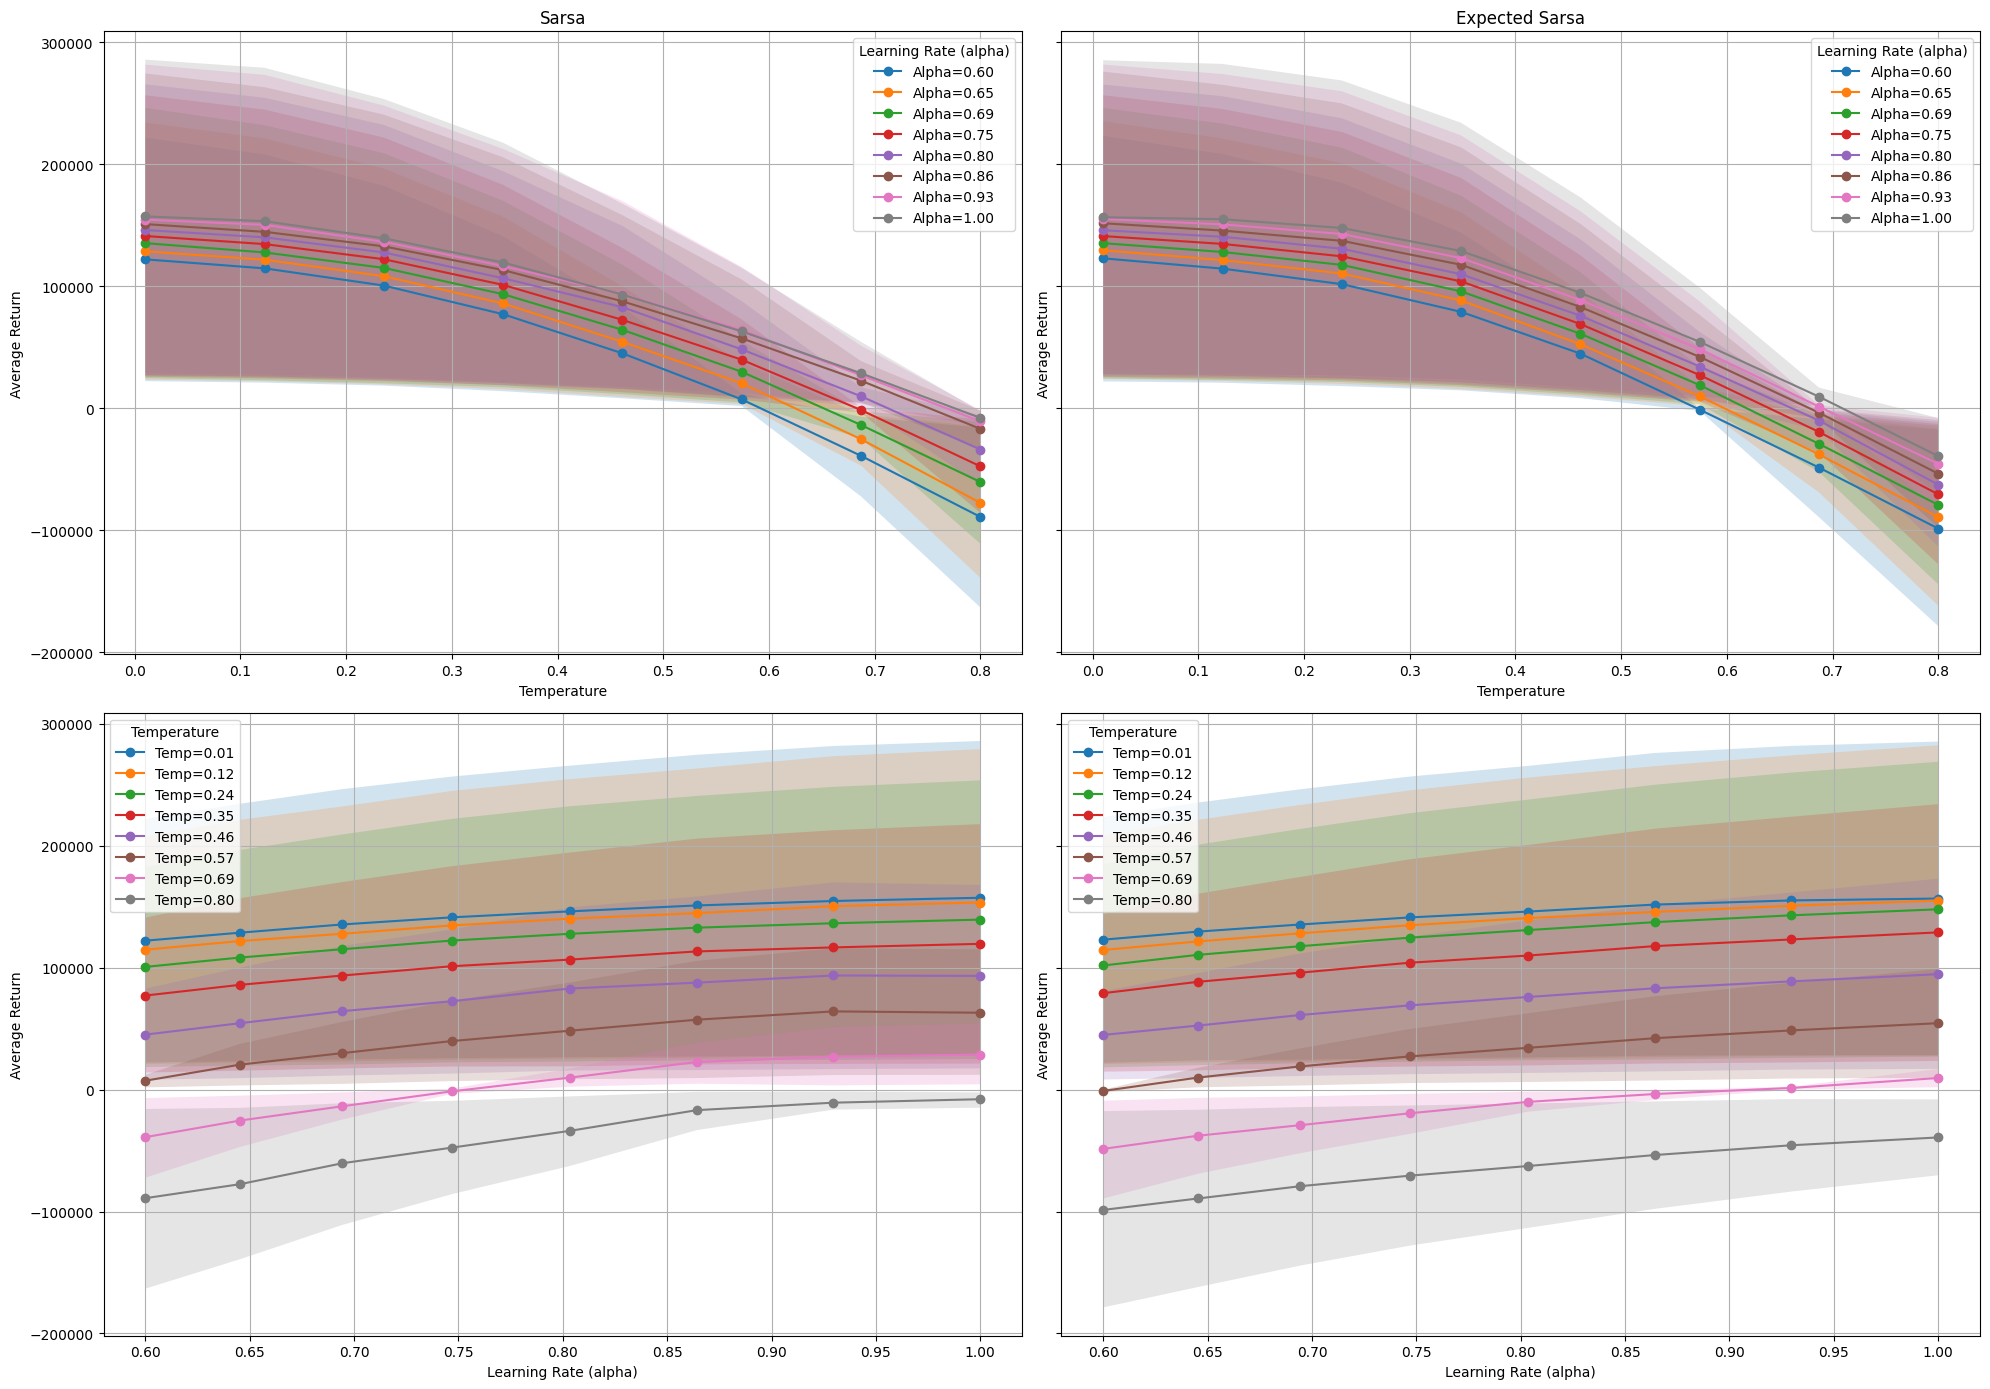

In [17]:
# Assuming `df` is your DataFrame
# Step 1: Filter to only include the last 10 training episodes of each segment
df_training_last_10 = train_df[(train_df['episode'] > n_episodes - 11) & (train_df['segment'] == n_segments-1)]

# Step 2: Group by model, hyperparameters, and segment, then calculate mean return for the last 10 episodes
grouped_means = df_training_last_10.groupby(['model_name', 'alpha', 'temp', 'run', 'trial', 'segment'])['return'].mean().reset_index()

# Step 3: Further aggregate across trials to get the mean, min, and max returns for each hyperparameter combination
final_stats = grouped_means.groupby(['model_name', 'alpha', 'temp']).agg(
    mean_return=('return', 'mean'),
    min_return=('return', 'min'),
    max_return=('return', 'max')
).reset_index()

# Setup the figure and axes for a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)

# Titles for each column (Sarsa vs Expected Sarsa)
column_titles = {'sarsa': 'Sarsa', 'expected_sarsa': 'Expected Sarsa'}
# Titles for the rows based on the x-axis variable
row_titles = ['Alpha', 'Temperature']

# Assuming final_stats is correctly structured and contains 'model_name' column with 'Sarsa' and 'Expected Sarsa'
for col_index, model in enumerate(column_titles):
    model_data = final_stats[final_stats['model_name'] == model]

    # First row plots: Alpha values
    unique_alphas = model_data['alpha'].unique()
    for alpha in unique_alphas:
        subset_alpha = model_data[model_data['alpha'] == alpha].sort_values(by='temp')
        if not subset_alpha.empty:  # Check if subset is not empty
            axes[0, col_index].plot(subset_alpha['temp'], subset_alpha['mean_return'], label=f'Alpha={alpha:.2f}', marker='o')
            axes[0, col_index].fill_between(subset_alpha['temp'], subset_alpha['min_return'], subset_alpha['max_return'], alpha=0.2)
    axes[0, col_index].set_title(column_titles[model])
    axes[0, col_index].set_xlabel('Temperature')
    axes[0, col_index].set_ylabel('Average Return')
    axes[0, col_index].legend(title='Learning Rate (alpha)')
    axes[0, col_index].grid(True)

    # Second row plots: Temperature values
    unique_temps = model_data['temp'].unique()
    for temp in unique_temps:
        subset_temp = model_data[model_data['temp'] == temp].sort_values(by='alpha')
        if not subset_temp.empty:  # Check if subset is not empty
            axes[1, col_index].plot(subset_temp['alpha'], subset_temp['mean_return'], label=f'Temp={temp:.2f}', marker='o')
            axes[1, col_index].fill_between(subset_temp['alpha'], subset_temp['min_return'], subset_temp['max_return'], alpha=0.2)
    axes[1, col_index].set_xlabel('Learning Rate (alpha)')
    axes[1, col_index].set_ylabel('Average Return')
    axes[1, col_index].legend(title='Temperature')
    axes[1, col_index].grid(True)

plt.tight_layout()
plt.show()

## Graph 2: Test performance

The same graph that instead shows the effect of the parameters on the final testing performance. The y-axis should now show the return during the final testing episode, averaged over the 10 runs.

<Axes: ylabel='Frequency'>

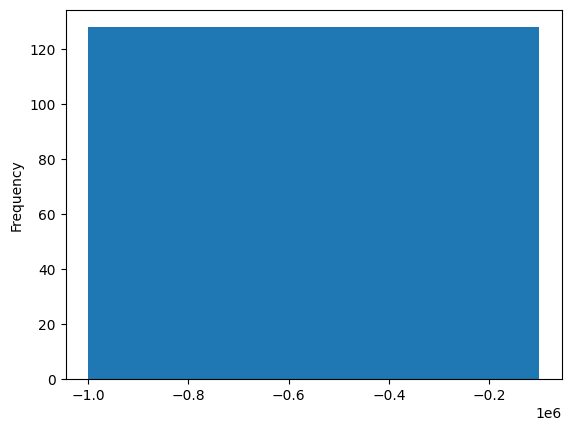

In [39]:
test_df.loc[test_df.segment == n_segments - 1, 'return'].plot(kind='hist')

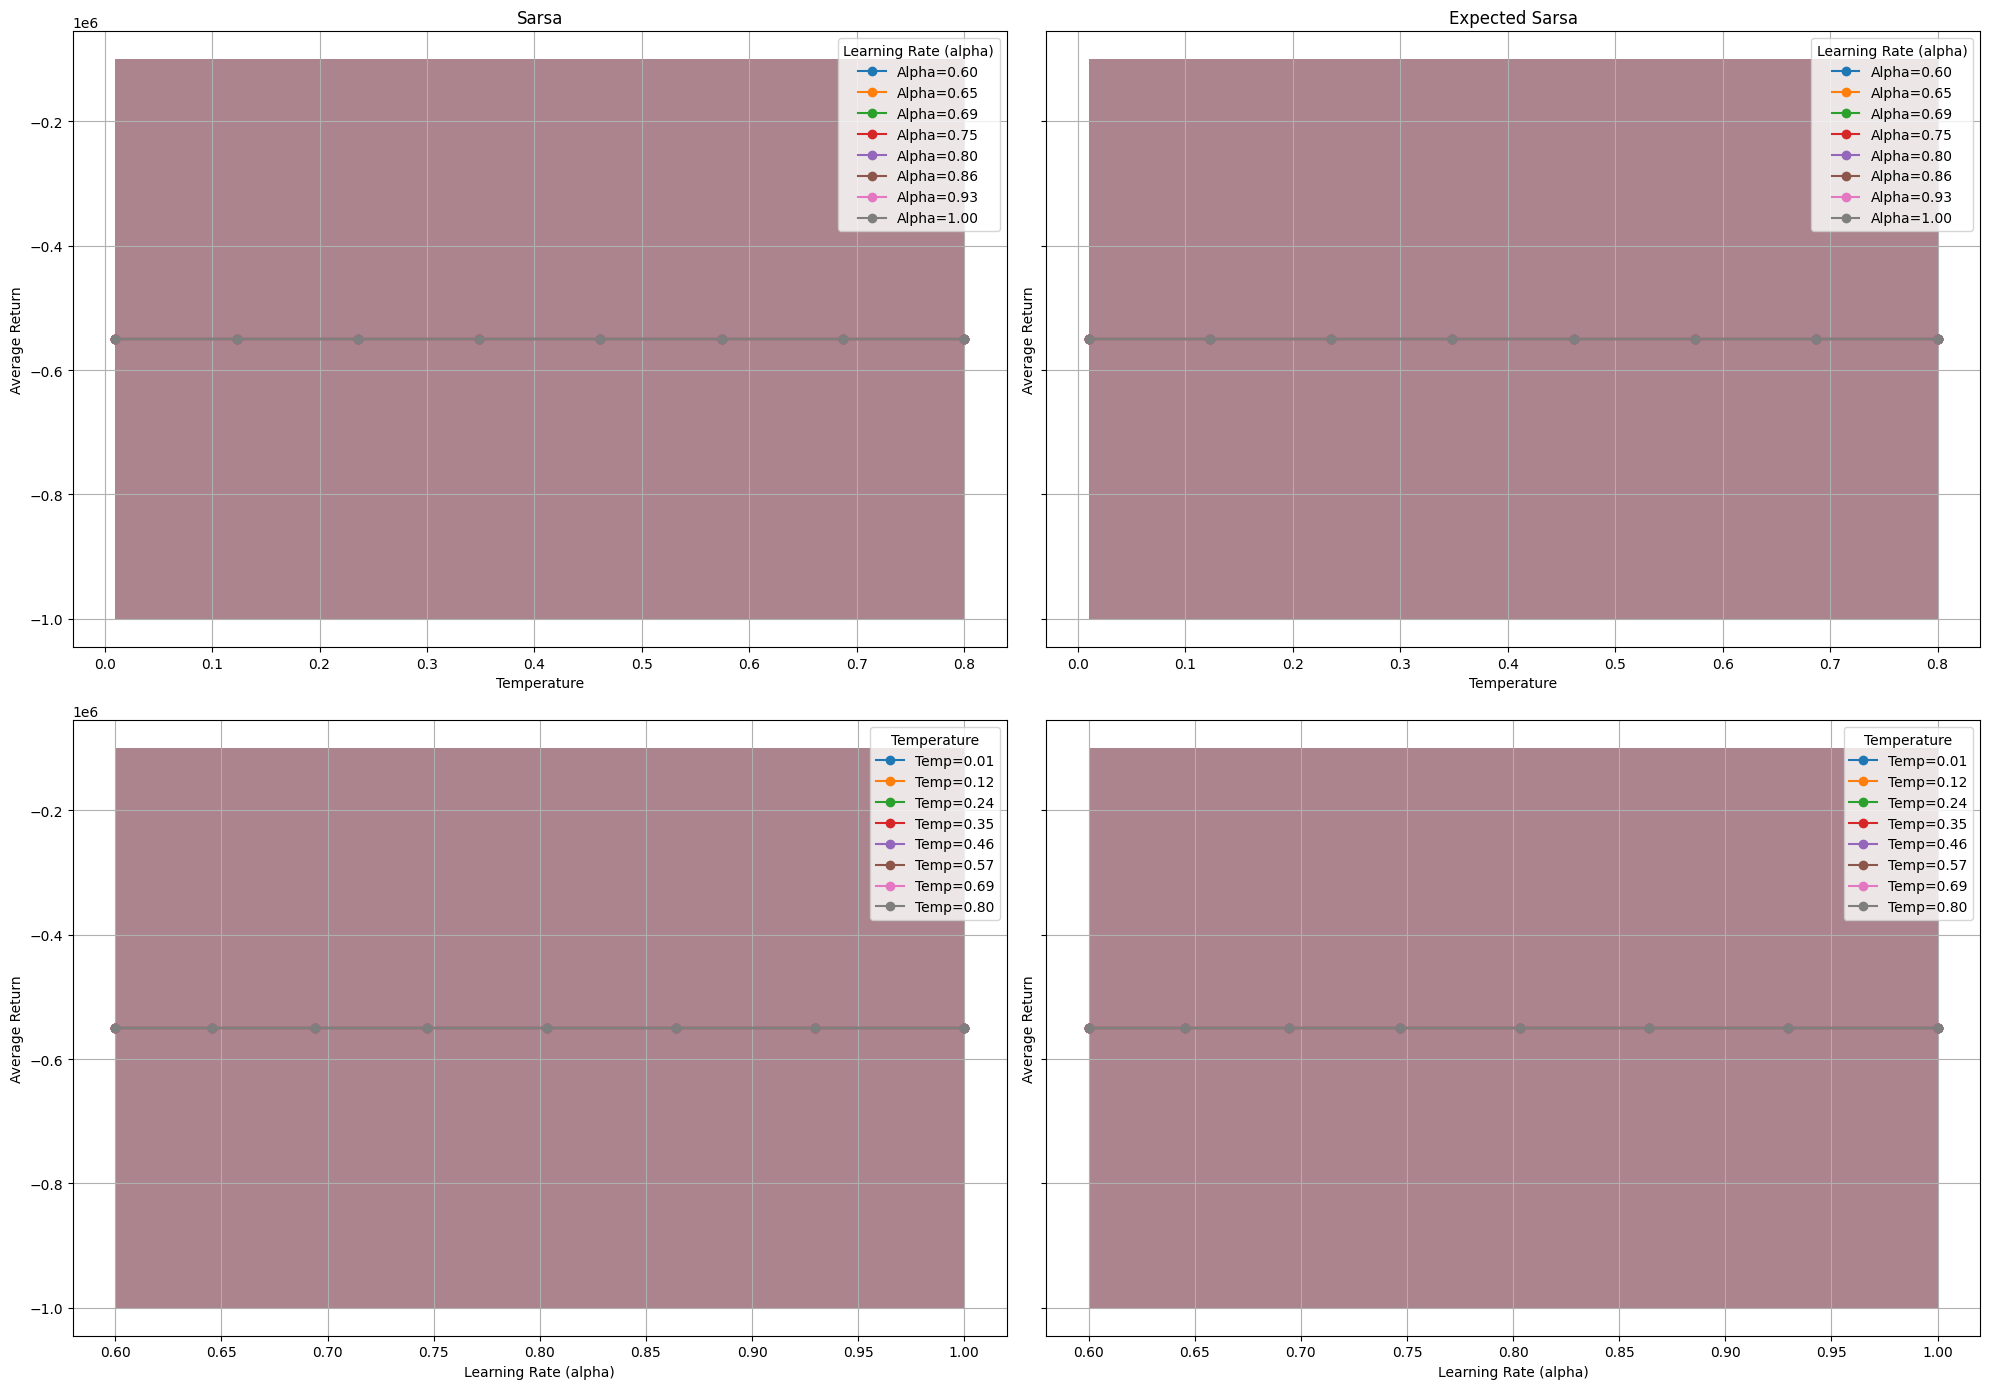

In [34]:
# Assuming `df` is your DataFrame
# Step 1: Filter to only include the last 10 training episodes of each segment
df_test_last_10 = test_df.loc[test_df.segment == n_segments - 1, :]

# Step 2: Group by model, hyperparameters, and segment, then calculate mean return for the last 10 episodes
grouped_means = df_test_last_10.groupby(['model_name', 'alpha', 'temp', 'run', 'trial', 'segment'])['return'].mean().reset_index()

# Step 3: Further aggregate across trials to get the mean, min, and max returns for each hyperparameter combination
final_stats = grouped_means.groupby(['model_name', 'alpha', 'temp']).agg(
    mean_return=('return', 'mean'),
    min_return=('return', 'min'),
    max_return=('return', 'max')
).reset_index()

# Setup the figure and axes for a 2x2 grid of plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)

# Titles for each column (Sarsa vs Expected Sarsa)
column_titles = {'sarsa': 'Sarsa', 'expected_sarsa': 'Expected Sarsa'}
# Titles for the rows based on the x-axis variable
row_titles = ['Alpha', 'Temperature']

# Assuming final_stats is correctly structured and contains 'model_name' column with 'Sarsa' and 'Expected Sarsa'
for col_index, model in enumerate(column_titles):
    model_data = final_stats[final_stats['model_name'] == model]

    # First row plots: Alpha values
    unique_alphas = model_data['alpha'].unique()
    for alpha in unique_alphas:
        subset_alpha = model_data[model_data['alpha'] == alpha].sort_values(by='temp')
        if not subset_alpha.empty:  # Check if subset is not empty
            axes[0, col_index].plot(subset_alpha['temp'], subset_alpha['mean_return'], label=f'Alpha={alpha:.2f}', marker='o')
            axes[0, col_index].fill_between(subset_alpha['temp'], subset_alpha['min_return'], subset_alpha['max_return'], alpha=0.2)
    axes[0, col_index].set_title(column_titles[model])
    axes[0, col_index].set_xlabel('Temperature')
    axes[0, col_index].set_ylabel('Average Return')
    axes[0, col_index].legend(title='Learning Rate (alpha)')
    axes[0, col_index].grid(True)

    # Second row plots: Temperature values
    unique_temps = model_data['temp'].unique()
    for temp in unique_temps:
        subset_temp = model_data[model_data['temp'] == temp].sort_values(by='alpha')
        if not subset_temp.empty:  # Check if subset is not empty
            axes[1, col_index].plot(subset_temp['alpha'], subset_temp['mean_return'], label=f'Temp={temp:.2f}', marker='o')
            axes[1, col_index].fill_between(subset_temp['alpha'], subset_temp['min_return'], subset_temp['max_return'], alpha=0.2)
    axes[1, col_index].set_xlabel('Learning Rate (alpha)')
    axes[1, col_index].set_ylabel('Average Return')
    axes[1, col_index].legend(title='Temperature')
    axes[1, col_index].grid(True)

plt.tight_layout()
plt.show()

## Graph 3: Learning curves

Learning curves (mean and standard deviation computed based on the 10 runs) for the best
parameter setting for each algorithm. X-axis shows the segment, Y-axis shows return over-
time.